Occasionally, the need might arise to generate your own custom legend for your data. I swear this happens often in the wild, but I'm pretty proud of how contrived an example I cooked up.

## Example

Let's say that we work for the Queenstown Ministry of Travel, that we have a naive understanding of causality, and that there's a second Titanic ship coming into our port, which we know will sink.

Our job is to create the cleanest visualization to explain how our new legislation mandating that "all laborers (Male, third-class passengers) boarding in Queenstown must be between the ages 28 and 30" is for their own good.

We'll start by loading up the Titanic data.

In [1]:
%pylab inline

from seaborn import load_dataset

df = load_dataset('titanic')

df.head(10)

Populating the interactive namespace from numpy and matplotlib


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


Then create a new feature, derived from a combination of sex, embark location, and the passenger class.

Inspecting, there are 18 different combinations of these three features.

In [2]:
df['sex_embark_class'] = df['sex'] + ' ' + df['embarked'] + ' ' + df['pclass'].astype(str)

df['sex_embark_class'].nunique()

18

Due to our shoddy understanding of statistics, the only things we care about communicating are the relationship between:

* Age
* Sex + Board Location + Class
* Mortality

As we're sufficiently convinced that these are all the features we need to make an accurate prediction when history repeats itself.

Plotting `death` by `age`, separated by `sex_embark_class`, we immediately stumble into a busy, uninformative graph.

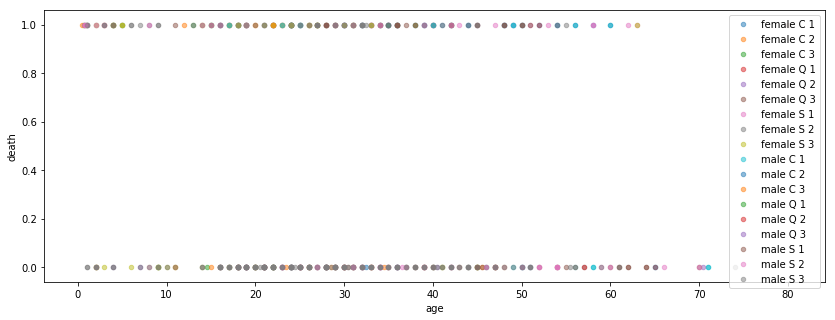

In [3]:
fig, ax = plt.subplots(figsize=(14, 5))

for idx, group in df.groupby('sex_embark_class'):
    ax.scatter(group['age'], group['survived'], alpha=.5, label=idx, s=20)
    
ax.set_xlabel('age')
ax.set_ylabel('death')
ax.legend();

Cleaning up a bit, we might generate a couple dictionaries to help us conditionally-color/size the markers, based on if they're in our target pop.

However, there's still the matter of the busy legend-- we don't care what all the other markers are. We're trying to separate this problem into a simple binary classification problem.

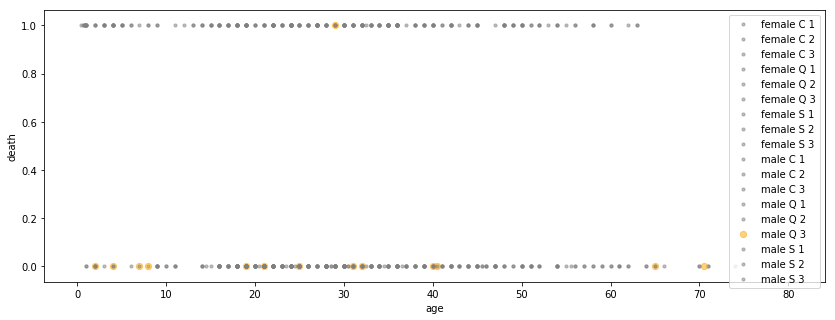

In [4]:
fig, ax = plt.subplots(figsize=(14, 5))

color_dict = {True: 'orange', False: 'grey'}
size_dict = {True: 40, False: 10}

for idx, group in df.groupby('sex_embark_class'):
    is_queenstown_laborer = (idx == 'male Q 3')
    ax.scatter(group['age'],
               group['survived'],
               alpha=.5,
               label=idx,
               s=size_dict[is_queenstown_laborer],
               c=color_dict[is_queenstown_laborer])
    
ax.set_xlabel('age')
ax.set_ylabel('death')    
ax.legend();

Shit. Changing the label didn't work.

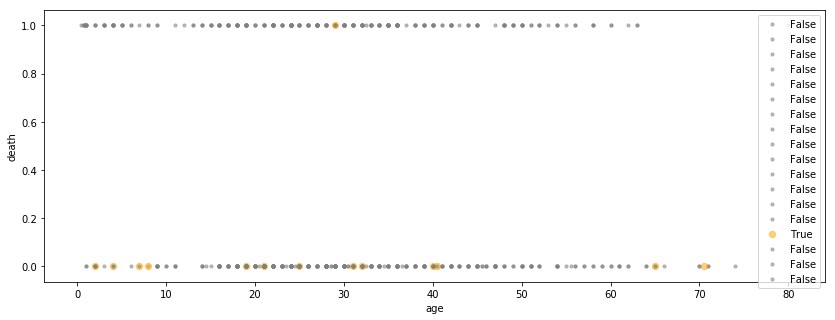

In [5]:
fig, ax = plt.subplots(figsize=(14, 5))

color_dict = {True: 'orange', False: 'grey'}
size_dict = {True: 40, False: 10}

for idx, group in df.groupby('sex_embark_class'):
    is_queenstown_laborer = (idx == 'male Q 3')
    ax.scatter(group['age'],
               group['survived'],
               alpha=.5,
               label=str(is_queenstown_laborer),
               s=size_dict[is_queenstown_laborer],
               c=color_dict[is_queenstown_laborer])
    
ax.set_xlabel('age')
ax.set_ylabel('death')    
ax.legend();

### The Point of this Notebook

Finally, we arrive at the motivation for this tutorial: The legend that gets generated for us is too busy, and we're not particularly interested in rewriting our DataFrame code to include a new field, just for the sake of vizualization.

Instead, we can use `matplotlib.patches.Rectangle` objects ([docs](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.patches.Rectangle.html)) like so

In [6]:
from matplotlib.patches import Rectangle

handles = [
    Rectangle((0, 0), 1, 1, color='orange'),
    Rectangle((0, 0), 1, 1, color='gray')    
]
labels = ['You', 'Not You']

Then, the main differences in our code are tossing the `label=idx` in the `ax.scatter()` call, and passing in `handles` and `labels` generated above.

I added the `axvline`s for more clarity.

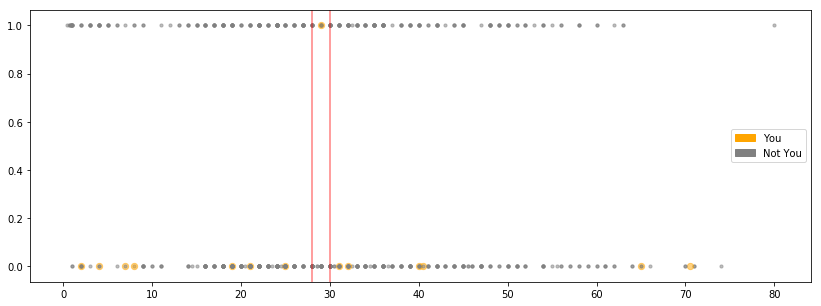

In [7]:
fig, ax = plt.subplots(figsize=(14, 5))

color_dict = {True: 'orange', False: 'grey'}
size_dict = {True: 40, False: 10}

for idx, group in df.groupby('sex_embark_class'):
    is_queenstown_laborer = (idx == 'male Q 3')
    ax.scatter(group['age'],
               group['survived'],
               alpha=.5,
               s=size_dict[is_queenstown_laborer],
               c=color_dict[is_queenstown_laborer])

ax.axvline(28, c='r', alpha=.5)
ax.axvline(30, c='r', alpha=.5)
ax.legend(handles, labels, loc='right');

Looking at that last call to `ax.legend()`, it's obvious to me what `labels` and `loc` mean. However, `handles` is less clear.

Reading up on it, it just looks like the terminology is just a legacy decision that's worth remembering, because [it's part of the vocabulary of the whole design of the legend feature.](https://matplotlib.org/tutorials/intermediate/legend_guide.html)